In [1]:
#C'est ici que toute la documentation du pipeline, les résultats et les analyses visuelles sont intégrés.
#Ce notebook contient les explications et appelle les scripts du dossier src/ pour exécuter chaque étape du pipeline.
#On l'utilise pour charger et exécuter le pipeline étape par étape. 
#Par exemple, pour exécuter la partie nettoyage, importer et exécuter data_preprocessing.py depuis src/.
#À chaque étape (nettoyage, analyse des données, visualisations), ajouter des cellules Markdown dans le notebook pour expliquer ce que fait chaque étape, pourquoi elle est nécessaire, et les observations tirées des résultats.
#C’est également ici que nous ajouterons les graphiques et analyses visuelles pour expliquer nos résultats intermédiaires.

In [2]:
#Expliquer ce que l'on fait dans notre projet et que pour ce faire nous utiliserons une version clean de movie_metadata.
#On affiche à partir de quelle année notre base de données de films commence pour exclure les évènements historiques trop lointains dans notre dataset additionnel.
#On veut garder la première colonne pour relier le film à son résumé mais aussi la plupart des autres.
#On veut transformer les formats de dates pour l’analyse temporelle.

# ADA Project - Milestone 2

First and foremost, we must setup the environment with the installation of appropriate libraries. 

In [3]:
from tests.test_data_preprocessing import test_cleaned_movie_data
import matplotlib.pyplot as plt 
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
import geopandas as gpd

Before beginning our study, we must proceed with data wrangling, transforming raw data into a structured and usable format for analysis.
This includes associating the correct names to our columns, removing outliers, nan and abherrent values and structuring our data so that it may be easier to work with. 

> # Movies dataset

## 1 - Data Collection

We begin with an initial overview of the raw imported data

In [4]:
raw_movies_data = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", header= None, delimiter='\t') # Columns are separated by tabs rather than commas
initial_length = len(raw_movies_data)
print("The initial dataframe has ", initial_length, "lines.")

The initial dataframe has  81741 lines.


In [5]:
raw_movies_data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 2 - Data Cleaning 

At the first steps of our analysis, we must name the columns for clarity, standardize the data and remove abherrent as well as nan values.

In [6]:
headers = ["Wikipedia movie ID",
    "Freebase movie ID",
    "Movie name",
    "Movie release date",
    "Movie box office revenue",
    "Movie runtime",
    "Movie languages (Freebase ID:name tuples)",
    "Movie countries (Freebase ID:name tuples)",
    "Movie genres (Freebase ID:name tuples)"]
raw_movies_data.columns = headers

The data in the columns for language, countries and genres is in a complex format that includes the Freebase ID. We need to extract and transform this data into a simpler format, making it ready for further analysis.
We can also drop the columns "Wikipedia movie ID" and "Freebase movie ID" because they won't be useful for our project. 

In [7]:
#remove the id, only keep the name
raw_movies_data["Languages"] = raw_movies_data["Movie languages (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data["Countries"] = raw_movies_data["Movie countries (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data["Genres"] = raw_movies_data["Movie genres (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data.drop(columns=["Wikipedia movie ID","Freebase movie ID", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"], inplace=True)
raw_movies_data.head(3)

,Movie name,Movie release date,Movie box office revenue,Movie runtime,Languages,Countries,Genres
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
2,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama"


In [8]:
#remove the word "Language" from the Languages column
raw_movies_data["Languages"] = raw_movies_data["Languages"].str.replace(r'\bLanguage\b', '', regex=True)

In [9]:
#remove rows with column "Country" containing a comma => this equals to removing rows with multiple countries
raw_movies_data = raw_movies_data[~raw_movies_data["Countries"].str.contains(",")]

### Handling missing values

We can use a heatmap to visualize the missing values from our raw data. Each white line corresponds to a missing value. 

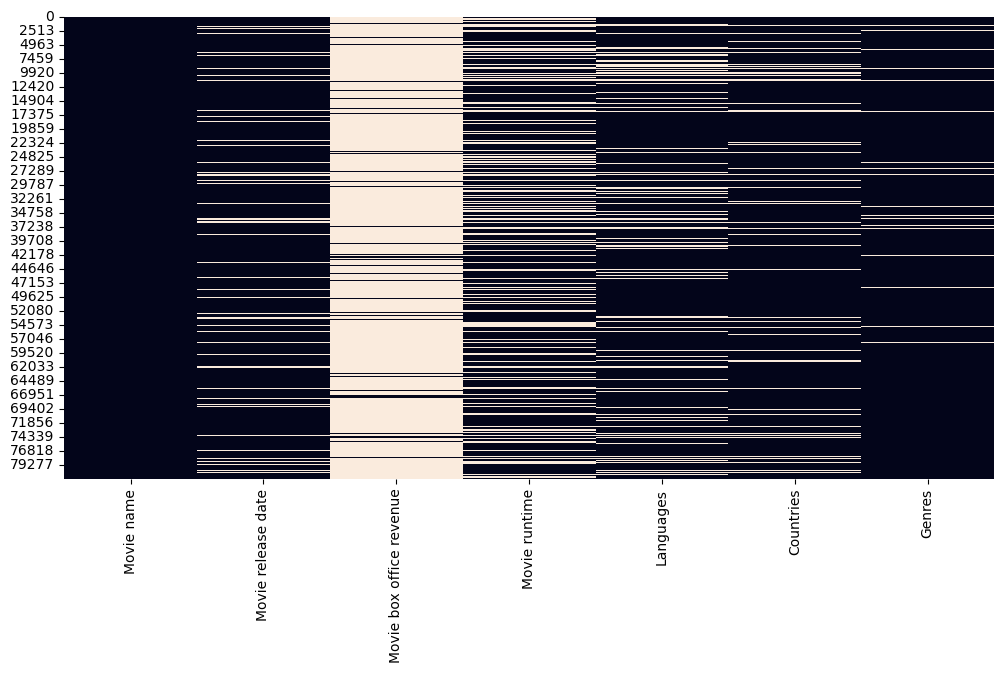

In [10]:
#Replace " " by NaN
clean_movies_data=raw_movies_data.copy()
clean_movies_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#Plot for the missing values
plt.figure(figsize=(12, 6))
sns.heatmap(clean_movies_data.isnull(), cbar=False)
plt.show()

The columns 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Languages', 'Countries' and 'Genres' contain a number of missing values. Let's quantify them :

In [11]:
#compute the percentage of missing values for each column
nb_missing_values = clean_movies_data.isnull().sum().sort_values(ascending=False)
missing_values_percentage = (clean_movies_data.copy().isnull().mean() * 100).sort_values(ascending=False)
#display in a dataframe
missing_values_df = pd.DataFrame({
    'Missing values': nb_missing_values,
    'Percentage (%)': missing_values_percentage
})
print(missing_values_df)

                          Missing values  Percentage (%)
Movie box office revenue           66003       91.009749
Movie runtime                      19897       27.435434
Languages                          13130       18.104601
Countries                           8154       11.243330
Movie release date                  6624        9.133654
Genres                              2238        3.085918
Movie name                             0        0.000000


Almost 90% of the movies are missing the information about the box office revenue, thus we cannot drop the rows with missing value in this column. However, our analysis focuses on movie genres so we need to drop the rows where the data for the movie genre is missing. By doing so, we loose around 2.8% of the data (2294 rows), which is reasonnable.

In [12]:
#The lines with nan values in genre are removed
clean_movies_data= clean_movies_data.dropna(subset=["Genres"])

Another fundamental variable for our project is the movie release date. Movies with missing data are unusable and must therefore be removed from the dataset. We are also removing missing data in the 'Countries' column as this is important for our analysis (à justifier un peu plus ?)

In [13]:
clean_movies_data = clean_movies_data.dropna(subset=["Movie release date"])
clean_movies_data = clean_movies_data.dropna(subset=["Countries"])
print(len(clean_movies_data))
percent_removed=(initial_length-len(clean_movies_data))/initial_length*100
print(f"{percent_removed:.2f}")

59252
27.51


After handling the missing values, we are left with 59252 movies in our data set. We removed 27.51% of the rows. This ensures that our analysis will stay pertinent

### Data standardization

We also observe that the movie release dates are in different formats, so we need to standardize the data. For our analysis, we will only need the year.

In [14]:
clean_movies_data['Year'] = clean_movies_data['Movie release date'].apply(extract_year)
clean_movies_data.drop(columns=["Movie release date"], inplace=True)
clean_movies_data.head()

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000
2,Brun bitter,NaN,83.0,Norwegian,Norway,"Crime Fiction, Drama",1988
3,White Of The Eye,NaN,110.0,English,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987
4,A Woman in Flames,NaN,106.0,German,Germany,Drama,1983


In [15]:
print(len(clean_movies_data))
clean_movies_data= clean_movies_data.dropna(subset=["Year"])
print(len(clean_movies_data))

59252
59251


The function extract_year failed to transform one date. The corresponding row is removed from the dataset

In [16]:
clean_movies_data['Year'].describe()

count     59251
unique      250
top        2008
freq       1181
Name: Year, dtype: int64

### Handling outliers

Now that we've looked at missing values, it is time to assess for outliers and abherrent values from our data. 

#### > Year

#### > Movie runtime

In [17]:
clean_movies_data['Movie runtime'].describe()

count    4.725500e+04
mean     1.157689e+02
std      4.964975e+03
min      0.000000e+00
25%      8.000000e+01
50%      9.200000e+01
75%      1.050000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

From the boxplot and statistical description of this variable, we are able to identify outliers. The maximum value (1 million) is clearly aberrant. The other outliers can be defined using a certain threshold range and removed from the dataset, but it is not needed for our project. 

There are 3302 outliers among the 47255 runtime values, which corresponds to 6.99% of the values.


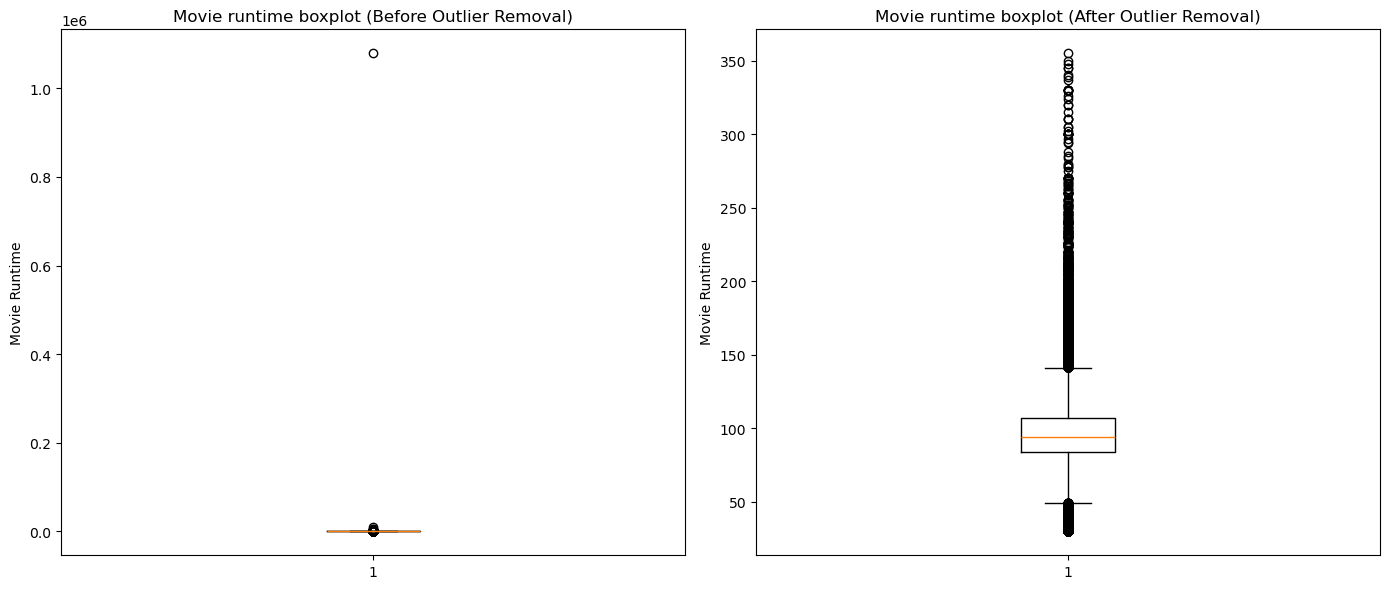

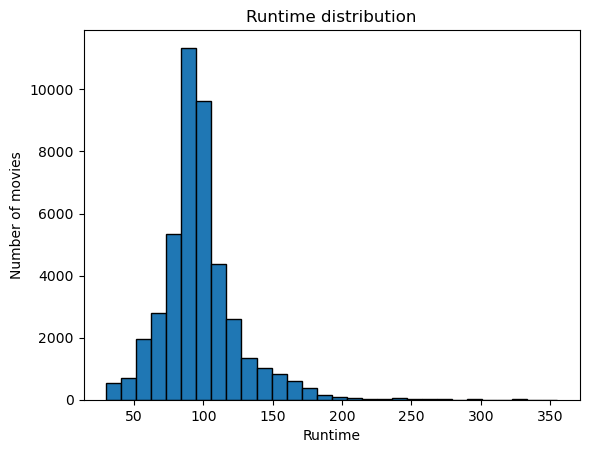

count    43953.000000
mean        97.411295
std         27.785218
min         30.000000
25%         84.000000
50%         94.000000
75%        107.000000
max        355.000000
Name: Movie runtime, dtype: float64

In [18]:
#Analysis of the column 'Runtime'
runtime_data=clean_movies_data['Movie runtime'].dropna()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Boxplot before outlier removal
ax[0].boxplot(runtime_data)
ax[0].set_title('Movie runtime boxplot (Before Outlier Removal)')
ax[0].set_ylabel('Movie Runtime')


#Identification of outliers
low_factor=2
up_factor = 10 #We choose a large factor because the distribution is right-skewed and we want to make sure that we do not exclude values that are not outliers
lower_bound, upper_bound=outliers_bounds(runtime_data, low_factor, up_factor)
outliers = runtime_data[(runtime_data < lower_bound) | (runtime_data > upper_bound)]
print(f"There are {len(outliers)} outliers among the {len(runtime_data)} runtime values, which corresponds to {len(outliers)/len(runtime_data)*100:.2f}% of the values.")

#Remove the outliers 
no_outlier_data=clean_movies_data.copy()
no_outlier_data = no_outlier_data[(no_outlier_data['Movie runtime'] >= lower_bound) & (no_outlier_data['Movie runtime'] <= upper_bound)]

#Boxplot after outlier removal
ax[1].boxplot(no_outlier_data['Movie runtime'])
ax[1].set_title('Movie runtime boxplot (After Outlier Removal)')
ax[1].set_ylabel('Movie Runtime')

#Adjust layout for better spacing
plt.tight_layout()

#Show the plots
plt.show()


#Runtime distribution
plt.figure()
plt.hist(no_outlier_data['Movie runtime'], bins=30, edgecolor='black')
plt.title('Runtime distribution')
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.show()

no_outlier_data['Movie runtime'].describe()

#### > Box Office

In [19]:
clean_movies_data['Movie box office revenue'].describe()

count    6.351000e+03
mean     4.434727e+07
std      1.039874e+08
min      1.000000e+04
25%      2.000000e+06
50%      9.832166e+06
75%      3.695581e+07
max      2.185372e+09
Name: Movie box office revenue, dtype: float64

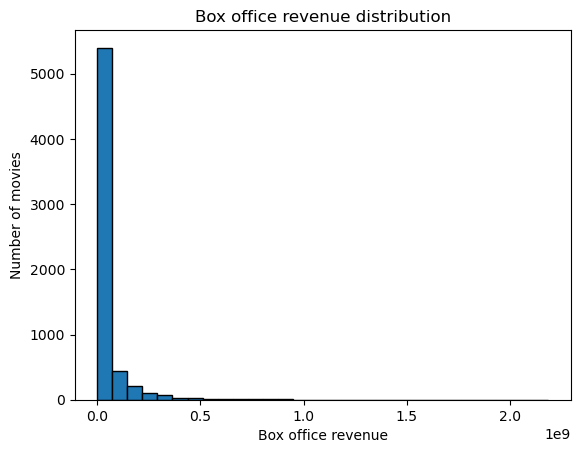

In [20]:
#Box office revenue distribution
plt.figure()
plt.hist(clean_movies_data['Movie box office revenue'], bins=30, edgecolor='black')
plt.title('Box office revenue distribution')
plt.xlabel('Box office revenue')
plt.ylabel('Number of movies')
plt.show()

In [21]:
top_10_box_office = clean_movies_data.sort_values(by='Movie box office revenue', ascending=False).head(10)
top_10_box_office

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
22256,Titanic,2.185372e+09,194.0,"Italian , English , French , Swedish , Russian...",United States of America,"Tragedy, Costume drama, Historical fiction, Ac...",1997
28192,The Avengers,1.511758e+09,137.0,"Russian , English",United States of America,"Science Fiction, Action",2012
18645,Transformers: Dark of the Moon,1.123747e+09,157.0,English,United States of America,"Alien Film, Science Fiction, Action, Adventure",2011
69586,Toy Story 3,1.063172e+09,102.0,"English , Spanish",United States of America,"Adventure, Children's/Family, Computer Animati...",2010
14303,Pirates of the Caribbean: On Stranger Tides,1.043872e+09,136.0,English,United States of America,"Swashbuckler films, Adventure, Costume Adventu...",2011
50039,Star Wars Episode I: The Phantom Menace,1.027045e+09,136.0,English,United States of America,"Science Fiction, Action, Fantasy, Adventure, F...",1999
73532,Pirates of the Caribbean: At World's End,9.634204e+08,169.0,English,United States of America,"Swashbuckler films, Fantasy Adventure, Adventu...",2007
21432,The Lion King,9.515838e+08,87.0,"Xhosa , Zulu , Swahili , English",United States of America,"Music, Adventure, Children's/Family, Animation...",1994
59393,Shrek 2,9.198388e+08,93.0,English,United States of America,"Adventure, Children's/Family, Computer Animati...",2004
63097,Jurassic Park,9.146911e+08,127.0,"English , Spanish",United States of America,"Thriller, Natural horror films, Science Fictio...",1993


There does not seem to be any significant outliers in this variable. This is reassuring because we are already quite limited in terms of number of instances as there are a great number of missing values for it.

### > Save the cleaned dataset

In [22]:
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)


In [23]:
print("The dataframe following preprocessing steps has ", len(clean_movies_data), "lines.")
print(len(raw_movies_data) - len(clean_movies_data), " lines were lost following the cleaning steps.")

The dataframe following preprocessing steps has  59251 lines.
13272  lines were lost following the cleaning steps.


## 3 - Preliminary Data Analysis

We wish to conduct an anaysis of the influence of historical and socio-cultural events on genre trends. Therefore we may begin observing the distribution of movie releases over time and the distribution of genres represented in our data.


### > Number of movies over time

It is important to note that for our future analysis that the number of films produced each year is not uniform. This variability should be considered when comparing film counts over time. In some cases, working with proportions rather than absolute numbers may provide us more interesting insights.


Text(0.5, 1.0, 'Number of movies per year')

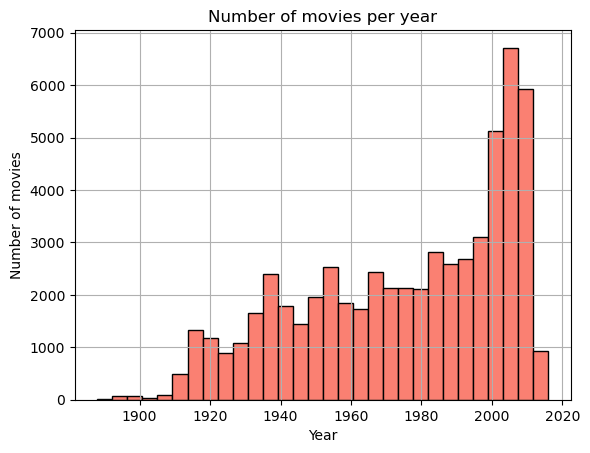

In [24]:
preprocessed_movies= pd.read_csv("data/Preprocessed_data/preprocessed_movie_metadata.csv")
preprocessed_movies["Year"].hist(bins=30, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.title("Number of movies per year")

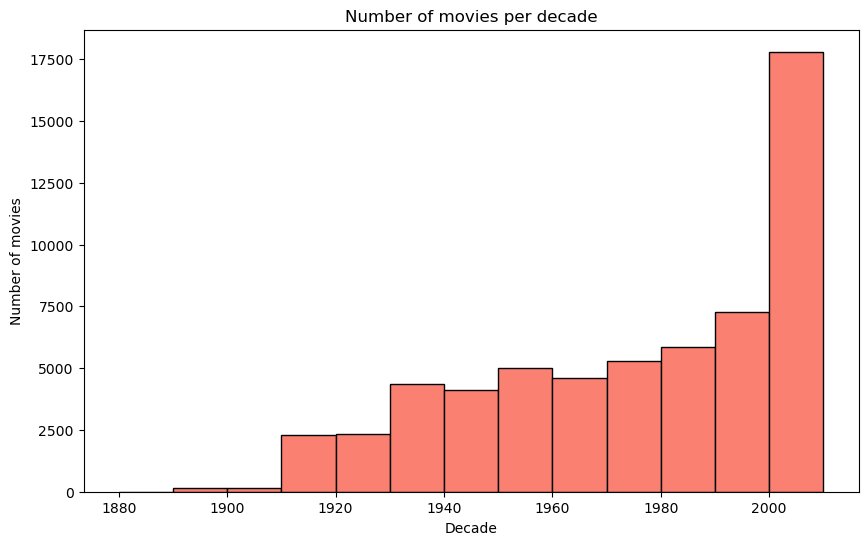

In [25]:
#Compute decade to which each movie corresponds
decades=(preprocessed_movies['Year'] // 10) * 10

#Histogram 
plt.figure(figsize=(10, 6))
decades.hist(bins=range(decades.min(), decades.max() + 10, 10), color='salmon', edgecolor='black')
plt.xlabel("Decade")
plt.ylabel("Number of movies")
plt.title("Number of movies per decade")
plt.grid(False)
plt.show()

### > Genre Movie exploring

In [26]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Genres'].str.split(', ').explode().unique()
print(len(genres),genres)

354 ['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' "Children's/Family" "Children's Fantasy" 'Future noir'
 'Comedy film' 'Coming of age' 'Bollywood' 'Marriage Drama' 'Wuxia'
 'Martial Arts Film' 'Chinese Movies' 'Western' 'Parody' 'Mockumentary'
 'Fan film' 'Cult' 'Adventure Comedy' 'Slapstick' 'Biopic [feature]'
 'Historical Epic' 'Historical fiction' 'Culture & Society' 'Biography'
 'Documentary' 'Christmas movie' 'Television movie' 'Malayalam Cinema'
 'Action Comedy' 'Blaxploitation' 'Erotica' 'Sci-Fi Horror' 'Satire'
 'Epic Western'

There are 363 different genres, many genres are used to described the film. Here a genre regroup a lot of information: the thematic, the technical characteristics, ... 
Clearly, not all of these information are useful for our analysis. We need to select to best to regroup the film in a meaningful way.

Let's count the number of movies in each genre category.

In [27]:
genres_counts = preprocessed_movies['Genres'].str.split(', ').explode().value_counts()
genres_counts

Genres
Drama                              25505
Comedy                             13583
Black-and-white                     8405
Romance Film                        7896
Action                              6560
                                   ...  
Ninja movie                            1
Camp                                   1
Breakdance                             1
The Netherlands in World War II        1
Revenge                                1
Name: count, Length: 354, dtype: int64

In [28]:
#Genres assigned to 10 movies or less
rare_genres = genres_counts[genres_counts <= 10]
rare_genres_counts = len(rare_genres)

print(f"Number of genres assigned to 10 movies or less  : {rare_genres_counts}")

Number of genres assigned to 10 movies or less  : 82


A lot of genres might not be meaningful because they contain few movies. In particular, 87 genres are assigned to 10 movies or less.
In order to keep only relevant genres, we can define an arbitrary threshold for the number of movies assigned to each genre.

In [29]:
#Threshold
threshold=50
# Garder uniquement les genres assignés à plus de 50 films
relevant_genres = genres_counts[genres_counts > 50]
print(f"Number of genres assigned to more than 500 movies : {len(relevant_genres)}")

Number of genres assigned to more than 500 movies : 182


Now we look at the distribution of the most widespread genres.

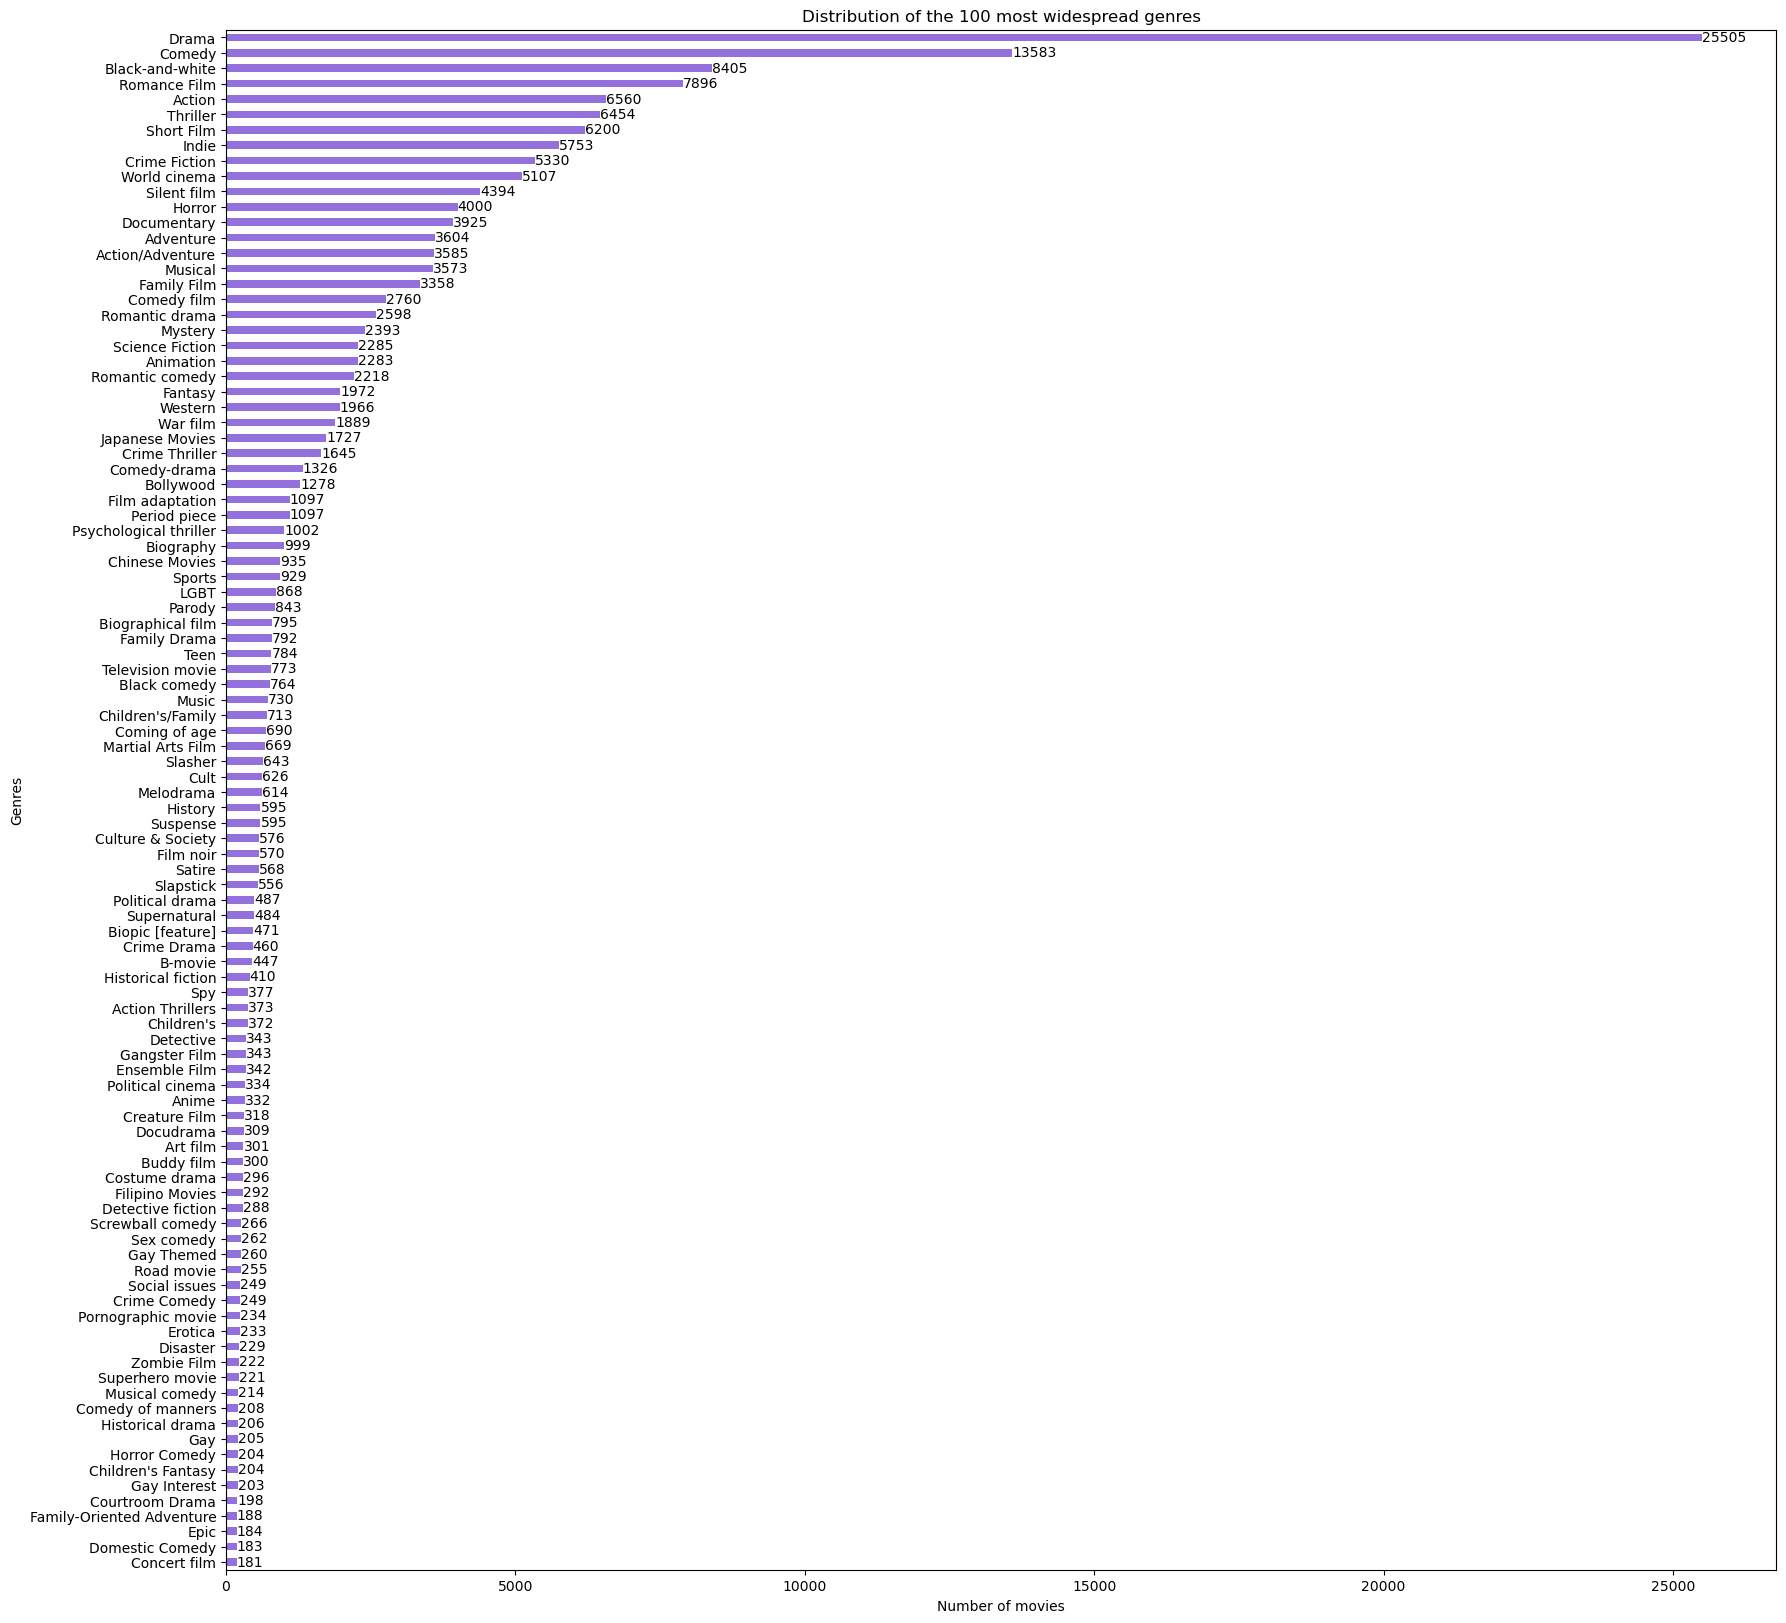

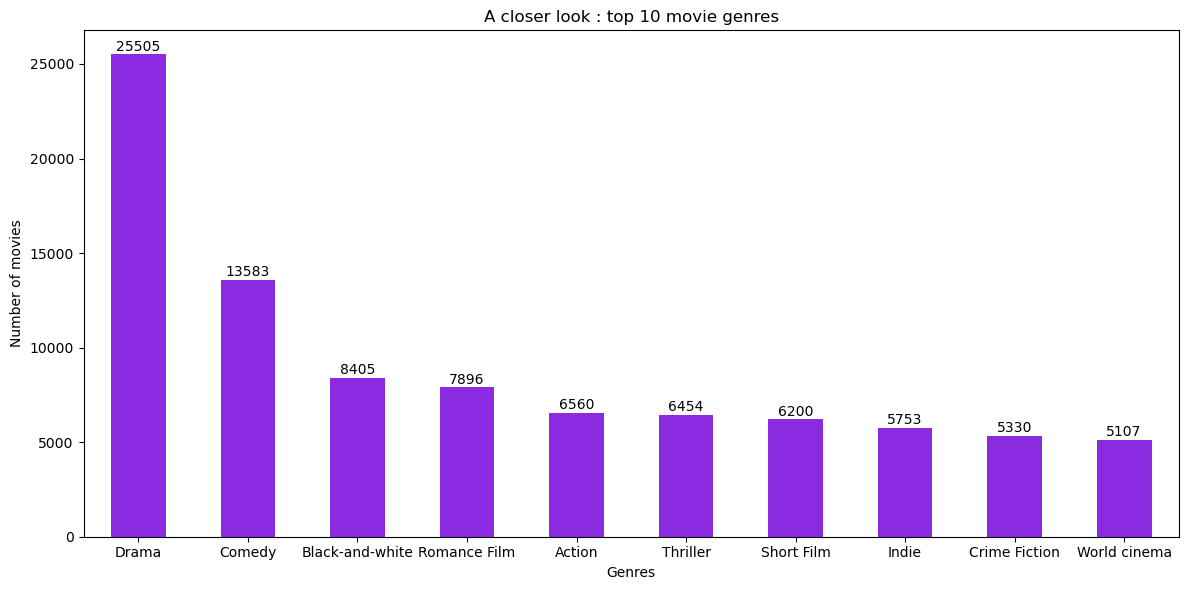

In [30]:
#We choose the 100 most widespread genres
top_100_genres = relevant_genres.head(100)

#Genres distribution
plt.figure(figsize=(20, 20))
top_100_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies')
plt.ylabel('Genres')
plt.title('Distribution of the 100 most widespread genres')
plt.gca().invert_yaxis() 

#Display the number of movies for each genre category
for index, value in enumerate(top_100_genres):
    plt.text(value, index, str(value), va='center')
    
plt.show()


#A closer look : top 10 movie genres
top_10_genres = relevant_genres.head(10)

#Bar plot 
plt.figure(figsize=(12, 6))
top_10_genres.plot(kind='bar', color='#8A2BE2')
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('A closer look : top 10 movie genres')

#Display the number of movies for each genre category
for index, value in enumerate(top_10_genres):
    plt.text(index, value + 200, str(value), ha='center')
    
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

## Petite tentative pour observer les war movies

In [31]:
War_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Genres'].str.contains(r'drama', case=False, na=False)]
print(len(War_movies), len(War_movies_comedy), len(War_movies_drama))

1902 175 1212


Text(0.5, 1.0, 'Number of movies per year')

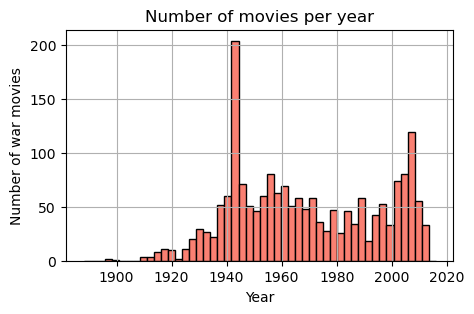

In [32]:
plt.figure(figsize=(5,3))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')

plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of movies per year")

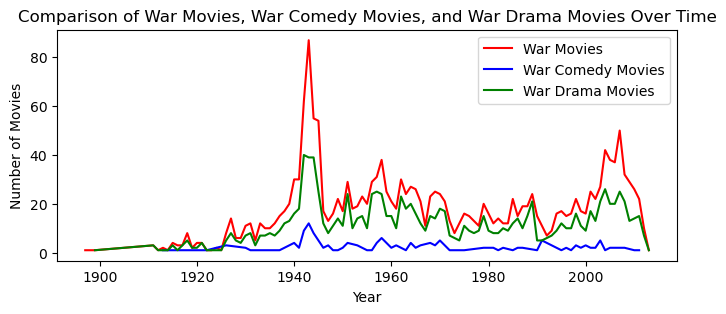

In [33]:
plt.figure(figsize=(8, 3))

# Count the number of movies in each category per year
war_movies_per_year = War_movies.groupby('Year').size()
war_comedy_movies_per_year = War_movies_comedy.groupby('Year').size()
war_drama_movies_per_year = War_movies_drama.groupby('Year').size()

# Plot the data
plt.plot(war_movies_per_year.index, war_movies_per_year.values, label='War Movies', color='red')
plt.plot(war_comedy_movies_per_year.index, war_comedy_movies_per_year.values, label='War Comedy Movies', color='blue')
plt.plot(war_drama_movies_per_year.index, war_drama_movies_per_year.values, label='War Drama Movies', color='green')

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Comparison of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend()
plt.show()



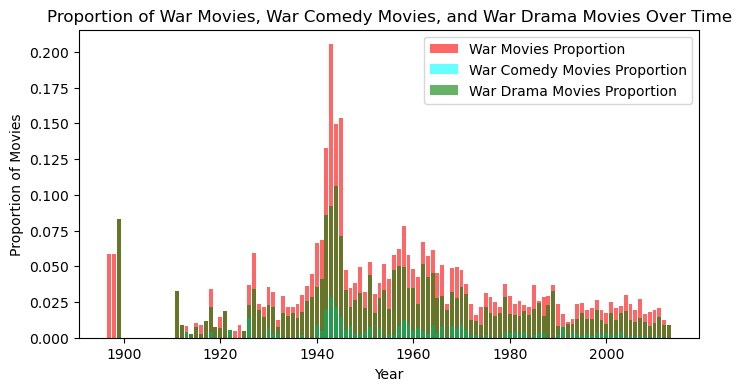

In [34]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_movies_proportion = war_movies_per_year / total_movies_per_year
war_comedy_movies_proportion = war_comedy_movies_per_year / total_movies_per_year
war_drama_movies_proportion = war_drama_movies_per_year / total_movies_per_year

plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

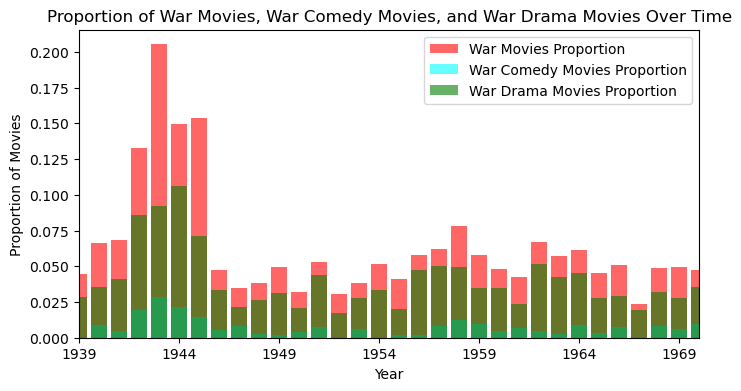

In [35]:
plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.xlim(1939, 1970)
plt.xticks(np.arange(1939, 1971, 5))
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

## Code qui vient de la branche de Lucile : Comment expliquer la variance des films avec un plus petit nombre de genres

In [36]:
#remove all the genre that give information about the technical aspect of the movie rather than the content
technical_information = ['Silent film','Short Film','Musical', 'Film adaptation',"Black-and-white", "Music", "Teen", "Stop Motion"]
country_information = ["Indie","Japanese Movies", "Chinese Movies", "Bollywood"]
unwanted_genres = technical_information + country_information


def filter_genres(genre_list, unwanted_genres):
    if isinstance(genre_list, str):
        genres = genre_list.split(', ')
        filtered_genres = [genre for genre in genres if genre not in unwanted_genres]
        return ', '.join(filtered_genres)
    return genre_list

preprocessed_movies['Genres'] = preprocessed_movies['Genres'].apply(lambda x: filter_genres(x, unwanted_genres=unwanted_genres))

In [37]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genres', 'Count']
genre_counts.head(4)

,Genres,Count
0,Drama,25505
1,Comedy,13583
2,Romance Film,7896
3,Action,6560


In [38]:
genre_counts_top_100 = genre_counts.iloc[:100]
genre_counts_top_30 = genre_counts.iloc[:30]
genre_counts_top_10 = genre_counts.iloc[:10]
genre_counts_top_3 = genre_counts.iloc[:3]

<Axes: xlabel='Genres'>

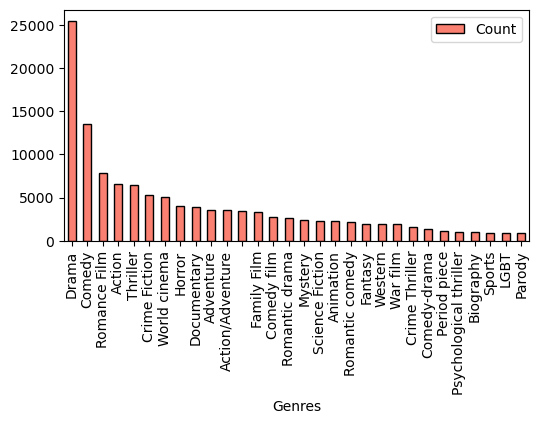

In [39]:
genre_counts_top_30.plot(kind='bar', x='Genres', y='Count', color='salmon', edgecolor='black', figsize=(6, 3))

In [40]:
def keep_only_the_most_common_genres(genre_list, genre_counts):
    if isinstance(genre_list, str):
        genres = genre_list.split(', ')
        filtered_genres = [genre for genre in genres if genre in genre_counts['Genres'].values]
        return ', '.join(filtered_genres)
    return genre_list

In [41]:
def most_common_genres(movies, genre_counts, top_n):
    movies_common_genre = movies.copy()

    #keep only the n top genres and replace the empty line by nan values
    movies_common_genre['Genres'] = movies_common_genre['Genres'].apply(lambda x: keep_only_the_most_common_genres(x, genre_counts=genre_counts))
    movies_common_genre['Genres'] = movies_common_genre['Genres'].apply(lambda x: np.nan if x == '' else x)
    
    #compute the portion of film qualified by the top n genre
    total = len(movies)
    covered = total - movies_common_genre['Genres'].isna().sum()
    coverage = (covered / total) * 100
    
    return movies_common_genre, coverage

# Define a list of genre counts for each top N genres
genre_counts_list = [genre_counts_top_100, genre_counts_top_30, genre_counts_top_10, genre_counts_top_3]
top_n_values = [100, 30, 10, 3]


coverages = {}
for top_n, genre_counts in zip(top_n_values, genre_counts_list):
    _, coverage = most_common_genres(preprocessed_movies, genre_counts, top_n)
    coverages[top_n] = coverage

for top_n, coverage in coverages.items():
    print(f"Number of films covered by the {top_n} major genres: {coverage:.2f}%")

print("-"*32)
print(f"60% of the film are classified into the third major genres that are \n" , genre_counts_top_3['Genres'].values,  f"\nUp to 91% of the film are classified into the 30 major genres that are: \n", genre_counts_top_10['Genres'].values)
print(f"\nThus by a few genre we can cover a large part of the movies, \nbut the remaining 9% of movies that are not covered by these major genres exhibit high variance, as they require many different genres to be classified")



Number of films covered by the 100 major genres: 93.63%
Number of films covered by the 30 major genres: 91.81%
Number of films covered by the 10 major genres: 83.80%
Number of films covered by the 3 major genres: 62.53%
--------------------------------
60% of the film are classified into the third major genres that are 
 ['Drama' 'Comedy' 'Romance Film'] 
Up to 91% of the film are classified into the 30 major genres that are: 
 ['Drama' 'Comedy' 'Romance Film' 'Action' 'Thriller' 'Crime Fiction'
 'World cinema' 'Horror' 'Documentary' 'Adventure']

Thus by a few genre we can cover a large part of the movies, 
but the remaining 9% of movies that are not covered by these major genres exhibit high variance, as they require many different genres to be classified


Let's try to do a heatmap to see if some genre are often associated together in a movie

In [42]:
most_10commongenres,coverage10 = most_common_genres(preprocessed_movies, genre_counts_top_10, 10)
most_10commongenres = most_10commongenres.dropna(subset=['Genres'])

In [43]:
#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_10commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_10commongenres.index)
genre_correlation = genre_binary_matrix.corr()


Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

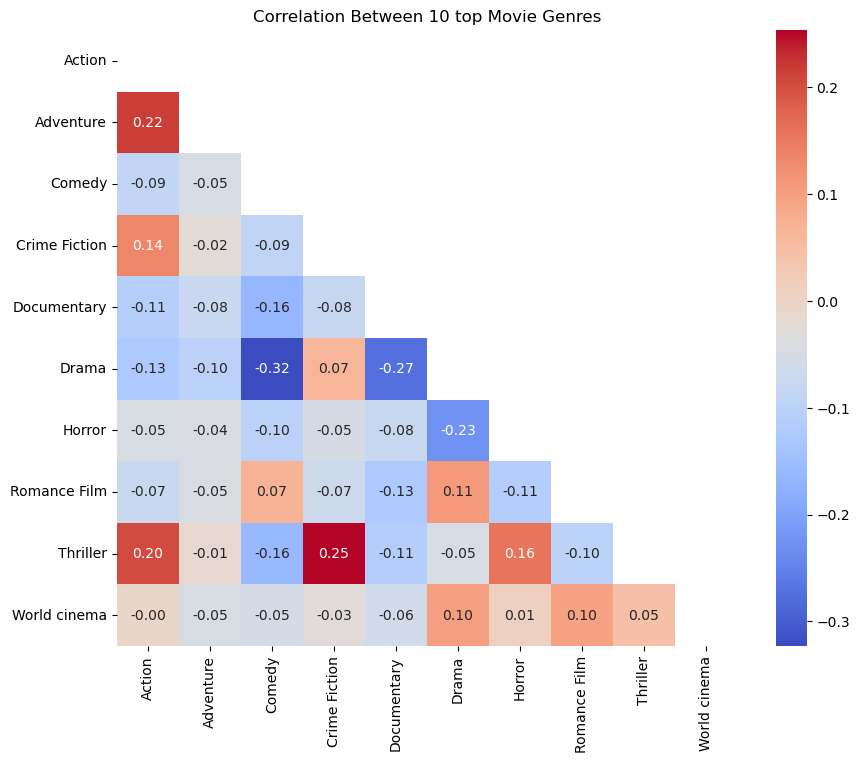

In [44]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')

This heatmap show how often 2 genres are used at the same time to describe the same moovie. 
For instance, between Adventure & Action (0.22): There is a moderate positive correlation, suggesting that movies in the "Adventure" genre often have elements of "Action" and vice versa. It shows a slight tendency for these genres to appear together in the same movies, but this co-occurrence is not strong or highly consistent across the dataset
Or between Drama & Documentary: there is a strong negative correlation indicates that movies classified as "Drama" are less likely to be "Documentary" and vice versa. Here the tendency for these 2 genre to not appear together in the same movie is stronger.

### Let's try this heat map for the top 30 genres

In [45]:
most_30commongenres,coverage30 = most_common_genres(preprocessed_movies, genre_counts_top_30, 30)
most_30commongenres = most_30commongenres.dropna(subset=['Genres'])

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_30commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_30commongenres.index)
genre_correlation = genre_binary_matrix.corr()

print(genre_correlation.index)

Index(['Action', 'Action/Adventure', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Comedy film', 'Comedy-drama', 'Crime Fiction',
       'Crime Thriller', 'Documentary', 'Drama', 'Family Film', 'Fantasy',
       'Horror', 'LGBT', 'Mystery', 'Parody', 'Period piece',
       'Psychological thriller', 'Romance Film', 'Romantic comedy',
       'Romantic drama', 'Science Fiction', 'Sports', 'Thriller', 'War film',
       'Western', 'World cinema'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

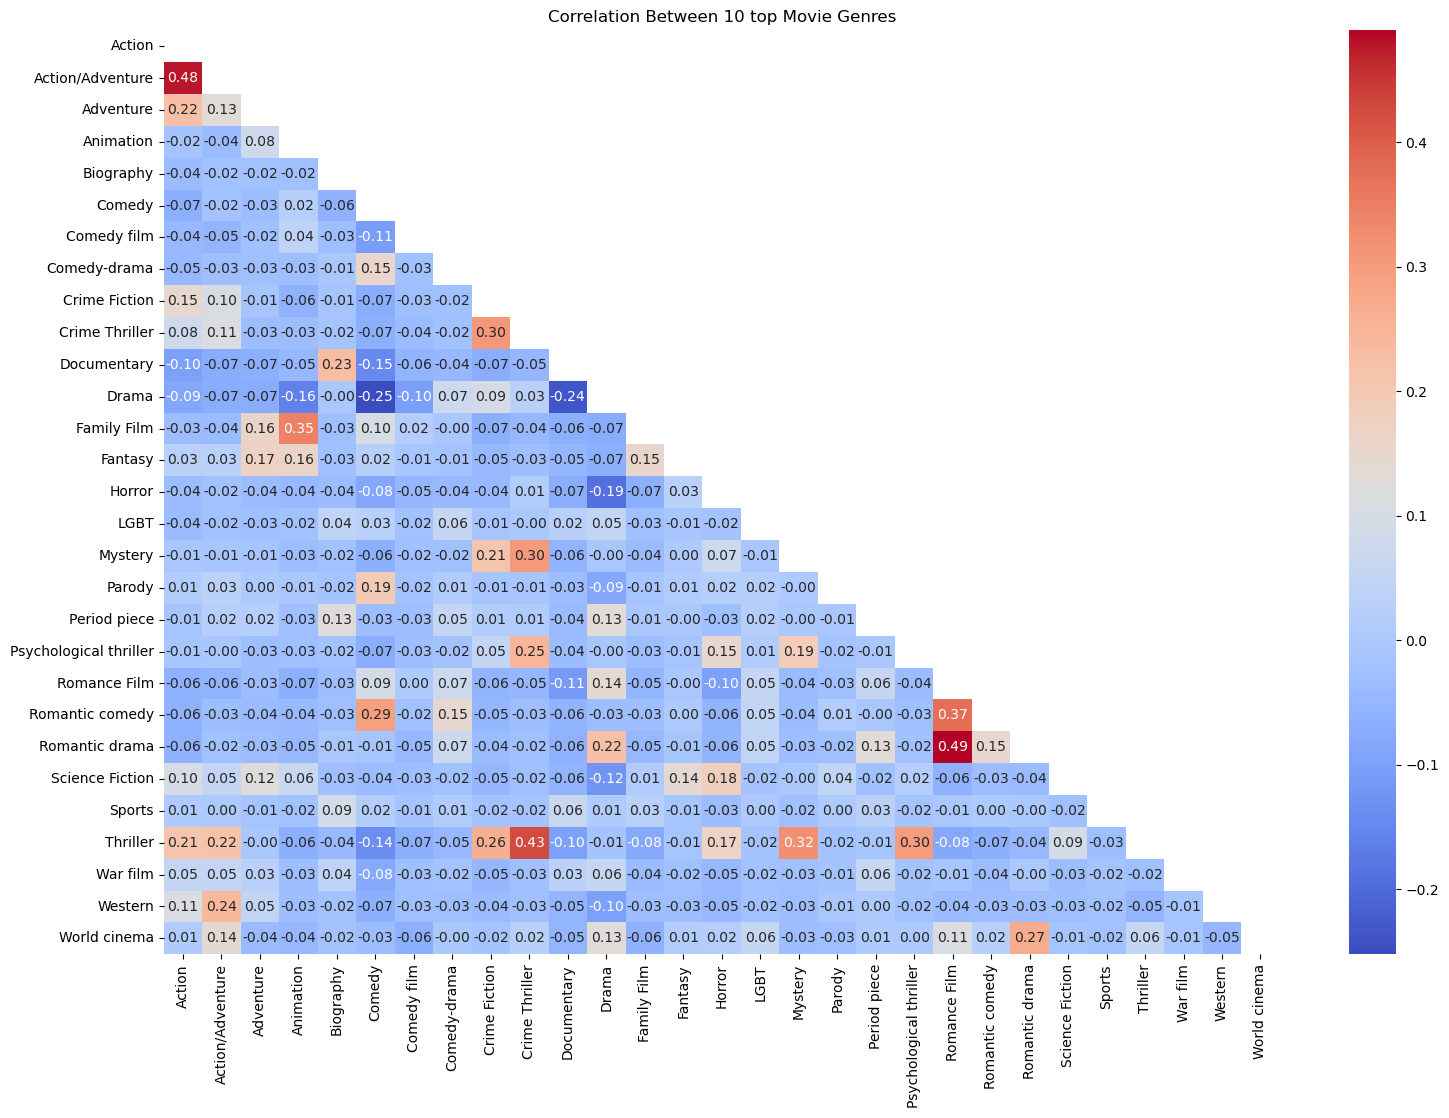

In [46]:
plt.figure(figsize=(18, 12))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')

Here, we observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.

## Brouillon de Lucile (commenté car il y a des erreurs)
-> "selected_genres" not defined 

In [47]:
# Create a new DataFrame to store the count of movies per year for each genre
# genre_year_df = preprocessed_movies[['Year', 'Genres']].copy()

# Explode the genres into separate rows
# genre_year_df = genre_year_df.assign(Movie_genres=genre_year_df['Genres'].str.split(', ')).explode('Genres')

# Filter the DataFrame to include only the selected genres
# genre_year_df = genre_year_df[genre_year_df['Genres'].isin(selected_genres)]

# Group by year and genre, and count the number of movies
# genre_year_counts = genre_year_df.groupby(['Year', 'Genres']).size().unstack(fill_value=0)

C:\Users\lauri\AppData\Local\Temp\ipykernel_37108\2027056179.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


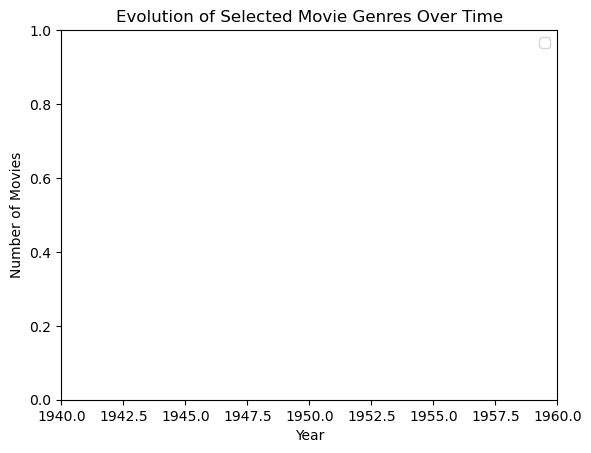

In [48]:
# Plot the evolution over time for each genre
#plt.figure(figsize=(14, 8))
#for genre in selected_genres:
#   plt.plot(genre_year_counts.index, genre_year_counts[genre], label=genre)

# Set the range for the x-axis
plt.xlim(1940, 1960)

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Evolution of Selected Movie Genres Over Time')
plt.legend()


In [49]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

In [50]:
len(genre_counts)

344

In [51]:
genre_counts_processed = genre_counts[genre_counts['Count'] > 100]
genre_counts_processed.head(30)


,Genre,Count
0,Drama,25505
1,Comedy,13583
2,Romance Film,7896
3,Action,6560
4,Thriller,6454
5,Crime Fiction,5330
6,World cinema,5107
7,Horror,4000
8,Documentary,3925
9,Adventure,3604


In [52]:
#HEATMAP 

In [53]:
Thriller_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'Thriller', case=False, na=False)]
Thriller_movies.head(13)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
3,White Of The Eye,NaN,110.0,English,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987
11,Lady Snowblood 2: Love Song of Vengeance,NaN,89.0,Japanese,Japan,"Crime Fiction, Thriller, World cinema, Action/...",1974
18,New Rose Hotel,21521.0,92.0,English,United States of America,"Thriller, Science Fiction, Future noir, Erotic...",1999
43,Kinjite: Forbidden Subjects,3416846.0,97.0,English,United States of America,"Crime Fiction, Action/Adventure, Action, Thriller",1989
62,Shivers,NaN,89.0,English,Canada,"Science Fiction, Horror, Erotica, Sci-Fi Horro...",1975
70,Sombra Verde,NaN,85.0,Spanish,Mexico,"Action/Adventure, Thriller, Drama, Adventure, ...",1954
80,The Boston Strangler,17810894.0,116.0,English,United States of America,"Crime Fiction, Mystery, Thriller, Drama, Crime...",1968
81,The Hero: Love Story of a Spy,NaN,182.0,Hindi,India,"Thriller, Action Thrillers, Adventure, World c...",2003
87,Choke Canyon,NaN,94.0,English,United States of America,"Thriller, Action Thrillers, Science Fiction, A...",1986


COMMENT ON CHOISIT LES CATEGORIES QU ON VEUT GARDER? 
- est ce qu on en combine, est ce on drop celle qui ont le moins de films, est ce qu on fait une selection manuelle?

# FIN DU RANDOM 

> # Additional dataset : "World Important Events - Ancient to Modern"

Enfin, on veut clean notre dataset additionnel, création de catégories utiles pour l’analyse, comme « guerre », « crise économique », « période de stabilité ». On cherche encore ici à vectoriser et mettre sous forme de token certains types de mots en identifiant les catégories qui nous intéressent.
On veut éliminer les valeurs manquantes ainsi que les événements historiques beaucoup trop vieux pour notre analyse.
Peu importe la méthode utilisée pour tokeniser/vectroriser, expliquer ici pourquoi c'est approprié pour nos objectif et donner une  brève explication mathématique si possible.
On veut aussi transformer les formats de dates pour l’analyse temporelle à l'image de notre movie dataset.

## 1 - Data Collection

In [54]:
from tests.test_data_preprocessing import test_cleaned_historical_data, test_vectorized_historical_data
import pandas as pd

raw_history_data = pd.read_csv("data/HistoricalDataset/historical.dataset.csv")
raw_history_data.head()

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,1,Indus Valley Civilization Flourishes,Unknown,Unknown,2600 BC,India,Civilization,Indus Valley,Development of one of the world's earliest urb...,Local inhabitants,Indus Valley people,Positive
1,2,Battle of the Ten Kings,Unknown,Unknown,1400 BC,India,Battle,Punjab,Rigvedic tribes consolidated their control ove...,Rigvedic tribes,Sudas,Positive
2,6,Establishment of the Delhi Sultanate,Unknown,Unknown,1206,India,Political,Delhi,Muslim rule established in parts of India,People of Delhi and surrounding regions,QutbUnknownudUnknowndin Aibak,Mixed
3,7,Battle of Panipat,21,April,1526,India,Battle,Panipat,Foundation of the Mughal Empire in India,Northern Indian kingdoms,Babur,Mixed
4,8,Establishment of British Raj,1,May,1858,India,Colonial,Whole India,Start of direct British governance in India,Indian subcontinent,British East India Company/Empire,Negative


In [55]:
len(raw_history_data)

1096

## 2 - Data Cleaning

We can remove the columns "Place Name","Date" and "Month" of the dataset. We don't need such precision in the historical events date because our analysis will focus on their impact on film industry, and films are usually released years after. The Place Name is also a precision that we won't need, as we are working at the scale of countries.

In [56]:
# drop columns that we don't need.
raw_history_data.drop(columns=["Place Name","Date", "Month","Sl. No"], inplace=True)

In [57]:
# we can see that some of the dates are before Christ (BC). We can safely remove them, knowing that movies didn't exist at that time.
cleaned_data_history = raw_history_data[~raw_history_data['Year'].str.contains('BC')]

The historical dataset starts from very ancient times, we want to only keep events happening after the first movie was released.

In [58]:
# for this purpose, we need to make the date values more convenient to work with, by converting the column ['Year'] from str to int
cleaned_data_history.loc[:, 'Year'] = cleaned_data_history.loc[:, 'Year'].astype(int)
    
# get the year of the first released movie
first_movie_year = preprocessed_movies['Year'].min()
print('\n In our dataset, the first movie that was released was in', int(first_movie_year))
    
# remove historical events that happened before the first movie was released
cleaned_data_history = cleaned_data_history[cleaned_data_history['Year'] >= first_movie_year]
first_event_year = cleaned_data_history['Year'].min()

print('\n The first event in the historical dataset that happened after the first movie was released was in', int(first_event_year))


 In our dataset, the first movie that was released was in 1888

 The first event in the historical dataset that happened after the first movie was released was in 1888


We chose to remove columns with mixed outcome because these corresponding events would be too complex for analyzing their direct impact on film industry.

In [59]:
#Drop rows with "Mixed" in the outcome column
cleaned_data_history = cleaned_data_history[cleaned_data_history["Outcome"] != "Mixed"]
cleaned_data_history.head()

,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
5,Partition of India,1947,India,Partition,Creation of India and Pakistan; massive popula...,"Hindus, Muslims, Sikhs","British Empire, Indian political leaders",Negative
6,IndoUnknownPakistani War of 1971,1971,India,War,Led to the independence of Bangladesh,Bengalis in East Pakistan,"Indian Military, Mukti Bahini",Negative
8,Mumbai Terror Attacks,2008,India,Terrorism,Highlighted the threat of international terrorism,Citizens of Mumbai,LashkarUnknowneUnknownTaiba,Negative
12,Swadeshi Movement,1905,India,National Movement,Promoted Indian goods; protest against British...,Indian nationalists,Indian National Congress,Positive
13,Green Revolution,1960,India,Agricultural Revolution,Dramatically increased agricultural production,Indian farmers,"M.S. Swaminathan, Norman Borlaug",Positive


To show on a world map the number of events happening in each country we will use a geopandas dataset. Some countries of the historical dataset have different names than geopandas, so we will need to format them to match. First of all, a primary analysis of these dfferences: 

In [60]:
# we can remove what is between parenthesis and remove outliers, for example, "Spain/USA". 

shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
geopandas_countries = world['NAME'].unique()
events_countries = cleaned_data_history['Country'].unique()

# Elements in events_countries but not in geopandas_countries
differences = [item for item in events_countries if item not in geopandas_countries]
print("These countries from events_countries are not taken into account in geopandas map", differences)

These countries from events_countries are not taken into account in geopandas map ['USSR', 'Korea', 'Singapore', 'Bukhara', 'Malaya', 'Tehran', 'Maldives', 'Basra', 'Punakha', 'Soviet Union', 'Uzbek SSR', 'Addu Atoll', 'Kuwait, Iraq', 'Mosul', 'Zhanaozen', 'USA', 'UK', 'Spain/USA', 'Equatorial Guinea', 'Seychelles', 'Cape Verde', 'GuineaUnknownBissau', 'Comoros', 'Central African Republic', 'Congo (Brazzaville)', "Ivory Coast (Côte d'Ivoire)", 'Swaziland (Eswatini)', 'South Sudan']


Here are the steps to make these countries match:

In [61]:
#Replace USSR and Soviet Union by Russia as we are interested in the geographical location of the events
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'USSR', 'Russia')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Soviet Union', 'Russia')

#replace name of countries to the appropriate format
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'USA', 'United States of America')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'UK', 'United Kingdom')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Zhanaozen', 'Kazakhstan')

#Actually ! 'Tehran' is the capital of Iran
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Tehran', 'Iran')

# remove all the remaining rows of the dataset that contain a country that is not in the geopandas map
cleaned_data_history = cleaned_data_history[cleaned_data_history['Country'].isin(geopandas_countries)]

In [62]:
len(cleaned_data_history)

612

The dataset is reduced to 612, but that's fine because we don't need a very large dataset for the historical events. Instead we want to choose relevant ones to analyse their impact on film industry.

## > Missing values

C:\Users\lauri\AppData\Local\Temp\ipykernel_37108\2710673950.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_data_history.replace(r'^\s*$', np.nan, regex=True, inplace=True)


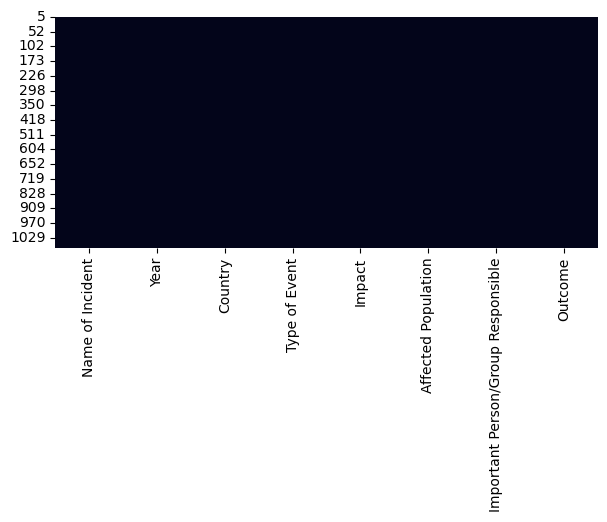

In [63]:
cleaned_data_history.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#Plot for the missing values
plt.figure(figsize=(7, 3))
sns.heatmap(cleaned_data_history.isnull(), cbar=False)
plt.show()

In [64]:
cleaned_data_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 5 to 1095
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Name of Incident                    612 non-null    object
 1   Year                                612 non-null    int64 
 2   Country                             612 non-null    object
 3   Type of Event                       612 non-null    object
 4   Impact                              612 non-null    object
 5   Affected Population                 612 non-null    object
 6   Important Person/Group Responsible  612 non-null    object
 7   Outcome                             612 non-null    object
dtypes: int64(1), object(7)
memory usage: 43.0+ KB


The heatmap and the .info() show that there are no missing values in the cleaned data history. 

### > Saving the cleaned data to a csv file

In [65]:
processed_data_path = 'data/Preprocessed_data/preprocessed_history.csv'
cleaned_data_history.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)
preprocessed_history = cleaned_data_history.copy()

In [66]:
print("The dataframe following preprocessing steps has ", len(preprocessed_history), "lines.")
print(len(raw_history_data) - len(preprocessed_movies), " lines were lost following the cleaning steps.")

The dataframe following preprocessing steps has  612 lines.
-58155  lines were lost following the cleaning steps.


## 3 - Preliminary Data Analysis

## Types of events

In [67]:
#Number of event types in the dataset
t_events = preprocessed_history['Type of Event'].str.split(', ').explode().unique()
print(len(t_events),t_events)

252 ['Partition' 'War' 'Terrorism' 'National Movement'
 'Agricultural Revolution' 'Military Operation' 'Military Conflict'
 'Legislation' 'Criminal Incident' 'Technology' 'Cultural/Religious'
 'Infrastructure' 'Political' 'Industrial Disaster' 'Economic Policy'
 'Cultural/Political' 'Education' 'Public Health' 'Sports'
 'Natural Disaster' 'Space Exploration' 'Financial Technology'
 'Telecommunications' 'Legal' 'Wildlife Conservation'
 'Environmental/Social' 'International Cooperation' 'Economic Reform'
 'Administrative' 'Massacre' 'Civil Disobedience Movement'
 'Violent Protest' 'Civil Disobedience' 'Political Declaration'
 'Mass Protest' 'Negotiation' 'Famine' 'Political Decision'
 'Political Integration' 'Constitutional Adoption'
 'Central Banking Institution' 'Space Agency' 'Political Party'
 'Regulatory Body' 'Country Formation' 'International Relations'
 'Constitutional' 'Economic/Infrastructure' 'Diplomatic/Religious'
 'International Finance' 'Military/Political' 'Monument'
 'Int

There are 252 different event types in the historical data. Just as we did for the genres in the movies, we can attempt to select a more relevant subset of these types. For this preliminary analysis, we can select a subset of these events (Wars for example? - maybe regroup war dates, see if there is a period with many wars which correlates with movies about war?)

Let's count the number of dates in each event type.

In [68]:
e_types_counts = preprocessed_history['Type of Event'].str.split(', ').explode().value_counts()
e_types_counts

Type of Event
Political                 50
Independence              34
Military                  20
Military Conflict         18
Terrorism                 15
                          ..
Constitutional/Legal       1
Legal/Constitutional       1
Legal/Social               1
Humanitarian/Political     1
Religious                  1
Name: count, Length: 252, dtype: int64

Looking at the distribution of types of events:

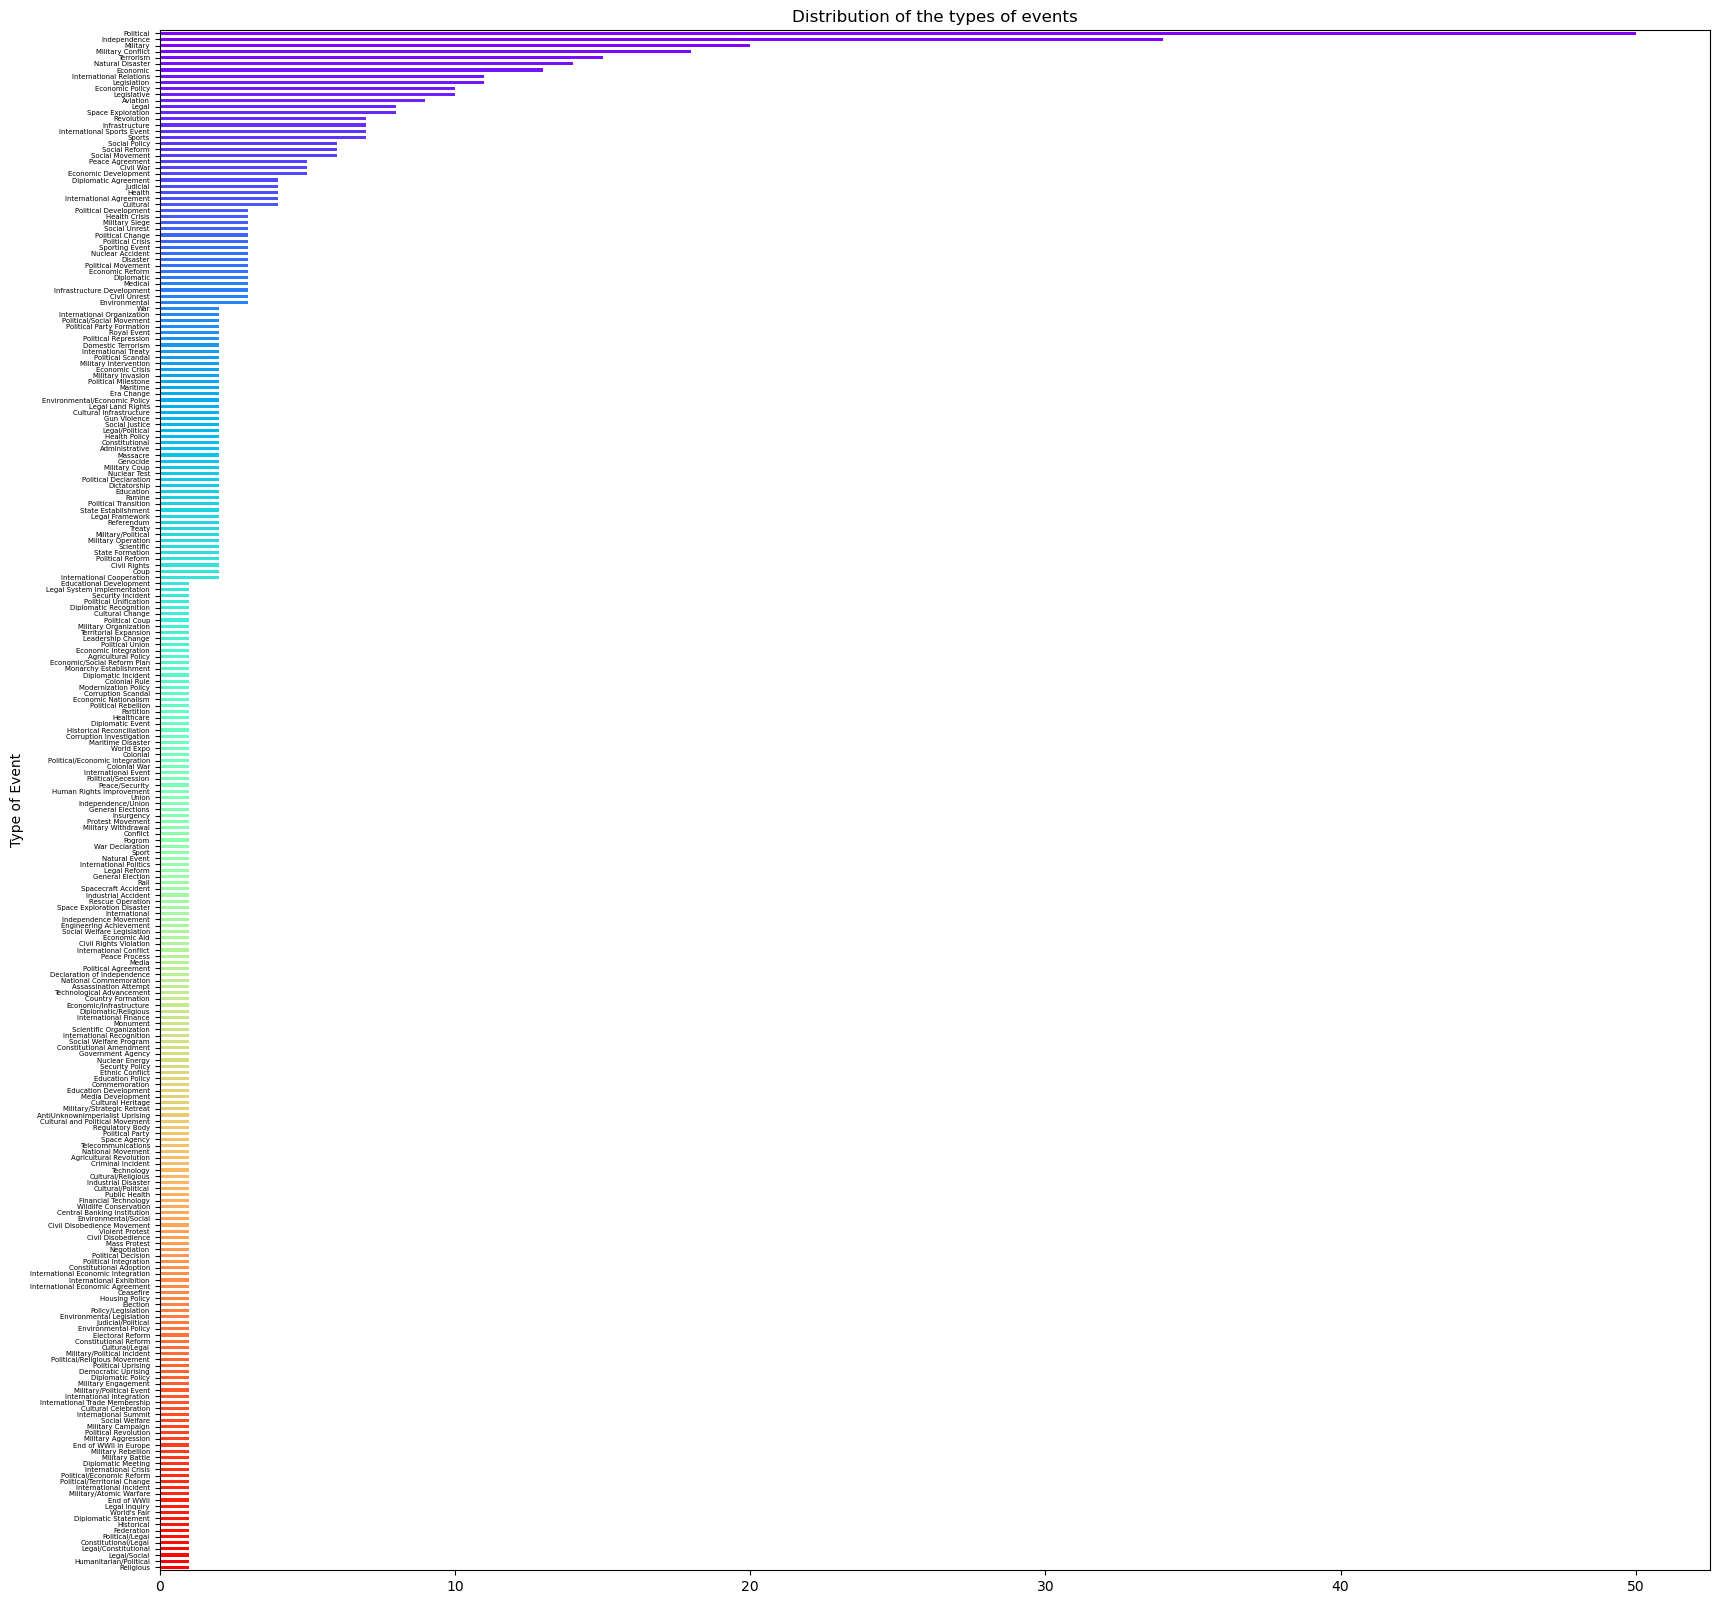

In [69]:
#Event type distribution

# For the bar colors
num_bars = len(e_types_counts)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

# Plot with rainbow colors assigned to each bar
plt.figure(figsize=(20, 20))
e_types_counts.plot(kind='barh', color=colors)
plt.title('Distribution of the types of events')
plt.yticks(fontsize=5) 
plt.gca().invert_yaxis() 



By quick visual analysis, we see that a large number of our types of events only have one occurence.

In [70]:
t_events = e_types_counts[e_types_counts <= 1]
rare_t_events = len(t_events)

print(f"Number of event types assigned to 10 dates or less  : {rare_t_events}")

Number of event types assigned to 10 dates or less  : 162


One way to select a subset of dates: by their number of assigned dates. This is however debatably relevant because some types of events could be rare but give a much better descriptive indication of the nature of the event. For example, the top represented types of events are "Political" and "Independence" which are quite vague in nature. Moreover, we see that "Military" and "Military Conflict" have a close number of occurences. This could mean that they have a strong association: we could therefore try to aggregate the event types that are always associated together. 

Lets analyse the correlation between types of events:

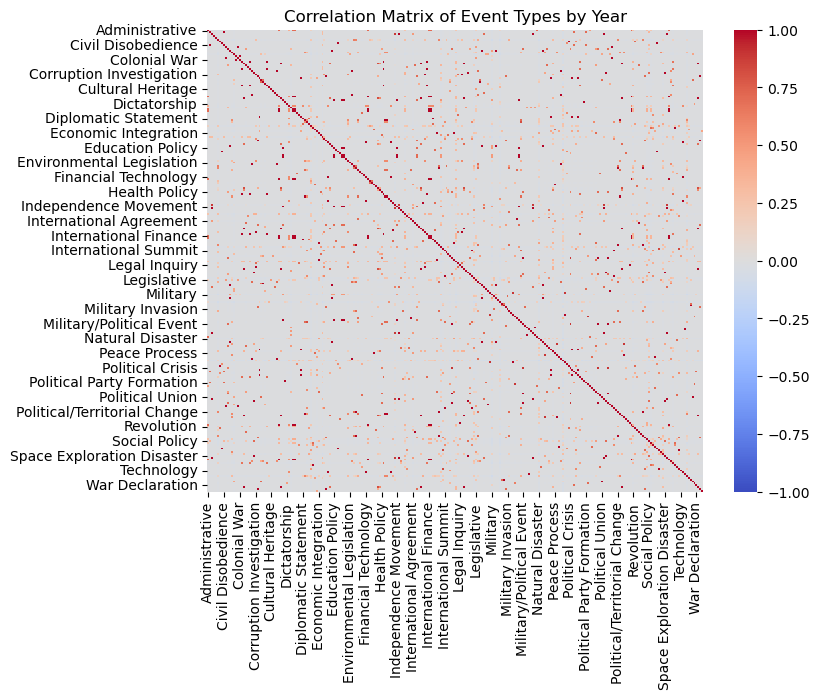

In [71]:
event_type_binary = pd.get_dummies(preprocessed_history['Type of Event'])
df_encoded = pd.concat([preprocessed_history[['Year']], event_type_binary], axis=1)
df_encoded
event_counts_by_year = df_encoded.groupby('Year').sum()
correlation_matrix = event_counts_by_year.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Event Types by Year')
plt.show()

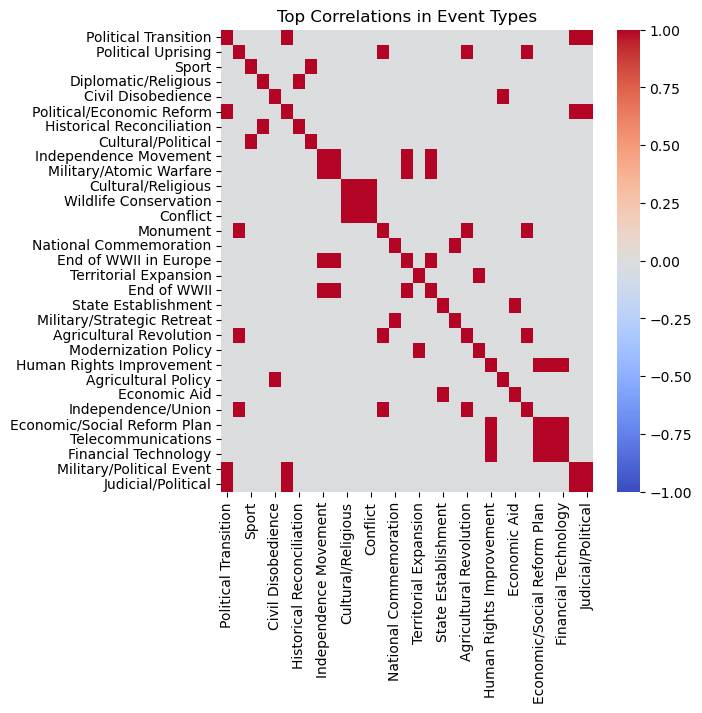

In [72]:
corr_values = correlation_matrix.unstack().reset_index()
corr_values.columns = ['Event Type 1', 'Event Type 2', 'Correlation']

# Step 1: Remove self-correlations (i.e., pairs where Event Type 1 == Event Type 2)
corr_values = corr_values[corr_values['Event Type 1'] != corr_values['Event Type 2']]

# Step 2: Sort the pairs by absolute correlation value
corr_values = corr_values.reindex(corr_values['Correlation'].abs().sort_values(ascending=False).index)

# Step 3: Select the top N highest correlations (e.g., top 5)
top_n = 20
top_corrs = corr_values.head(top_n)

# Step 4: Create a subset matrix with only the top N correlations
top_event_types = list(set(top_corrs['Event Type 1']).union(set(top_corrs['Event Type 2'])))
subset_matrix = correlation_matrix.loc[top_event_types, top_event_types]

# Display the subset matrix
#print("Subset of the correlation matrix (top correlations):")
#print(subset_matrix)

# Visualize the subset matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(subset_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Top Correlations in Event Types')
plt.show()

In [73]:
corr_values

,Event Type 1,Event Type 2,Correlation
59004,Sport,Cultural/Political,1.000000
62766,Wildlife Conservation,Conflict,1.000000
39884,Military/Atomic Warfare,End of WWII,1.000000
39885,Military/Atomic Warfare,End of WWII in Europe,1.000000
39912,Military/Atomic Warfare,Independence Movement,1.000000
...,...,...,...
24059,Independence,International Sports Event,0.001513
45535,Political,Peace Agreement,-0.001473
44280,Peace Agreement,Political,-0.001473
29871,International Relations,Legislation,0.001253


In [74]:

# remove self-correlations (i.e., pairs where Event Type 1 == Event Type 2)
corr_values = corr_values[corr_values['Event Type 1'] != corr_values['Event Type 2']]

# get the occurrences of event types (frequencies) from e_types_counts
event_occurrences = e_types_counts

# aggregate event types with a correlation of 1
highly_correlated = corr_values[corr_values['Correlation'] == 1]

# perform aggregation: Replace the event type with frequency 1
aggregated_corr_values = []
maintained_event_types = []  # List to keep track of the event types that are maintained

for _, row in highly_correlated.iterrows():
    event1, event2 = row['Event Type 1'], row['Event Type 2']
    
    # Check the frequencies of both event types
    freq_event1 = event_occurrences.get(event1, np.nan)
    freq_event2 = event_occurrences.get(event2, np.nan)
    
    # Replace the event with frequency 1
    if freq_event1 == 1 and freq_event2 != 1:
        # Replace event1 with event2
        aggregated_corr_values.append({
            'Event Type 1': event2, 
            'Event Type 2': event2, 
            'Correlation': 1
        })
        # Track which event type is maintained (event2 is maintained)
        maintained_event_types.append(event2)
    elif freq_event2 == 1 and freq_event1 != 1:
        # Replace event2 with event1
        aggregated_corr_values.append({
            'Event Type 1': event1, 
            'Event Type 2': event1, 
            'Correlation': 1
        })
        # Track which event type is maintained (event1 is maintained)
        maintained_event_types.append(event1)
    else:
        # If neither has frequency 1, keep the original pair
        aggregated_corr_values.append({
            'Event Type 1': event1, 
            'Event Type 2': event2, 
            'Correlation': row['Correlation']
        })
        # Track both event types as maintained
        maintained_event_types.append(event1)
        maintained_event_types.append(event2)

# Convert the aggregated list back into a DataFrame
aggregated_corr_values_df = pd.DataFrame(aggregated_corr_values)

# Display the aggregated correlations
print("\nAggregated Correlations:")
print(aggregated_corr_values_df)

# Display the maintained event types
print("\nMaintained Event Types:")
print(set(maintained_event_types))  # Using set to avoid duplicates


Aggregated Correlations:
                    Event Type 1                Event Type 2  Correlation
0                          Sport          Cultural/Political          1.0
1          Wildlife Conservation                    Conflict          1.0
2        Military/Atomic Warfare                 End of WWII          1.0
3        Military/Atomic Warfare       End of WWII in Europe          1.0
4        Military/Atomic Warfare       Independence Movement          1.0
..                           ...                         ...          ...
341          Political/Secession                Legal/Social          1.0
342  Central Banking Institution  Social Welfare Legislation          1.0
343         Cultural Celebration    Constitutional Amendment          1.0
344           Political Uprising     Agricultural Revolution          1.0
345    Historical Reconciliation            Protest Movement          1.0

[346 rows x 3 columns]

Maintained Event Types:
{'General Election', 'Corruption Scan

Bon tout compte fait c'est pas hyper pertinent ce que j'ai fait la donc a voir si on garde mais je pense laisser tomber. En gros j'essayer de voir si je pouvais grouper les types d'events sous le plus grand mais ca a l'air un peu bourbier.

For the time being, in order to study a manageble subset of the data, we can concentrate on a arbitrary type of event. War for example.

### > Geographical distribution of events

In [75]:
country_counts = preprocessed_history['Country'].value_counts()
country_counts

Country
India                       56
United States of America    40
Australia                   35
Pakistan                    35
Russia                      32
                            ..
Senegal                      1
Botswana                     1
Côte d'Ivoire                1
Madagascar                   1
Mexico                       1
Name: count, Length: 75, dtype: int64

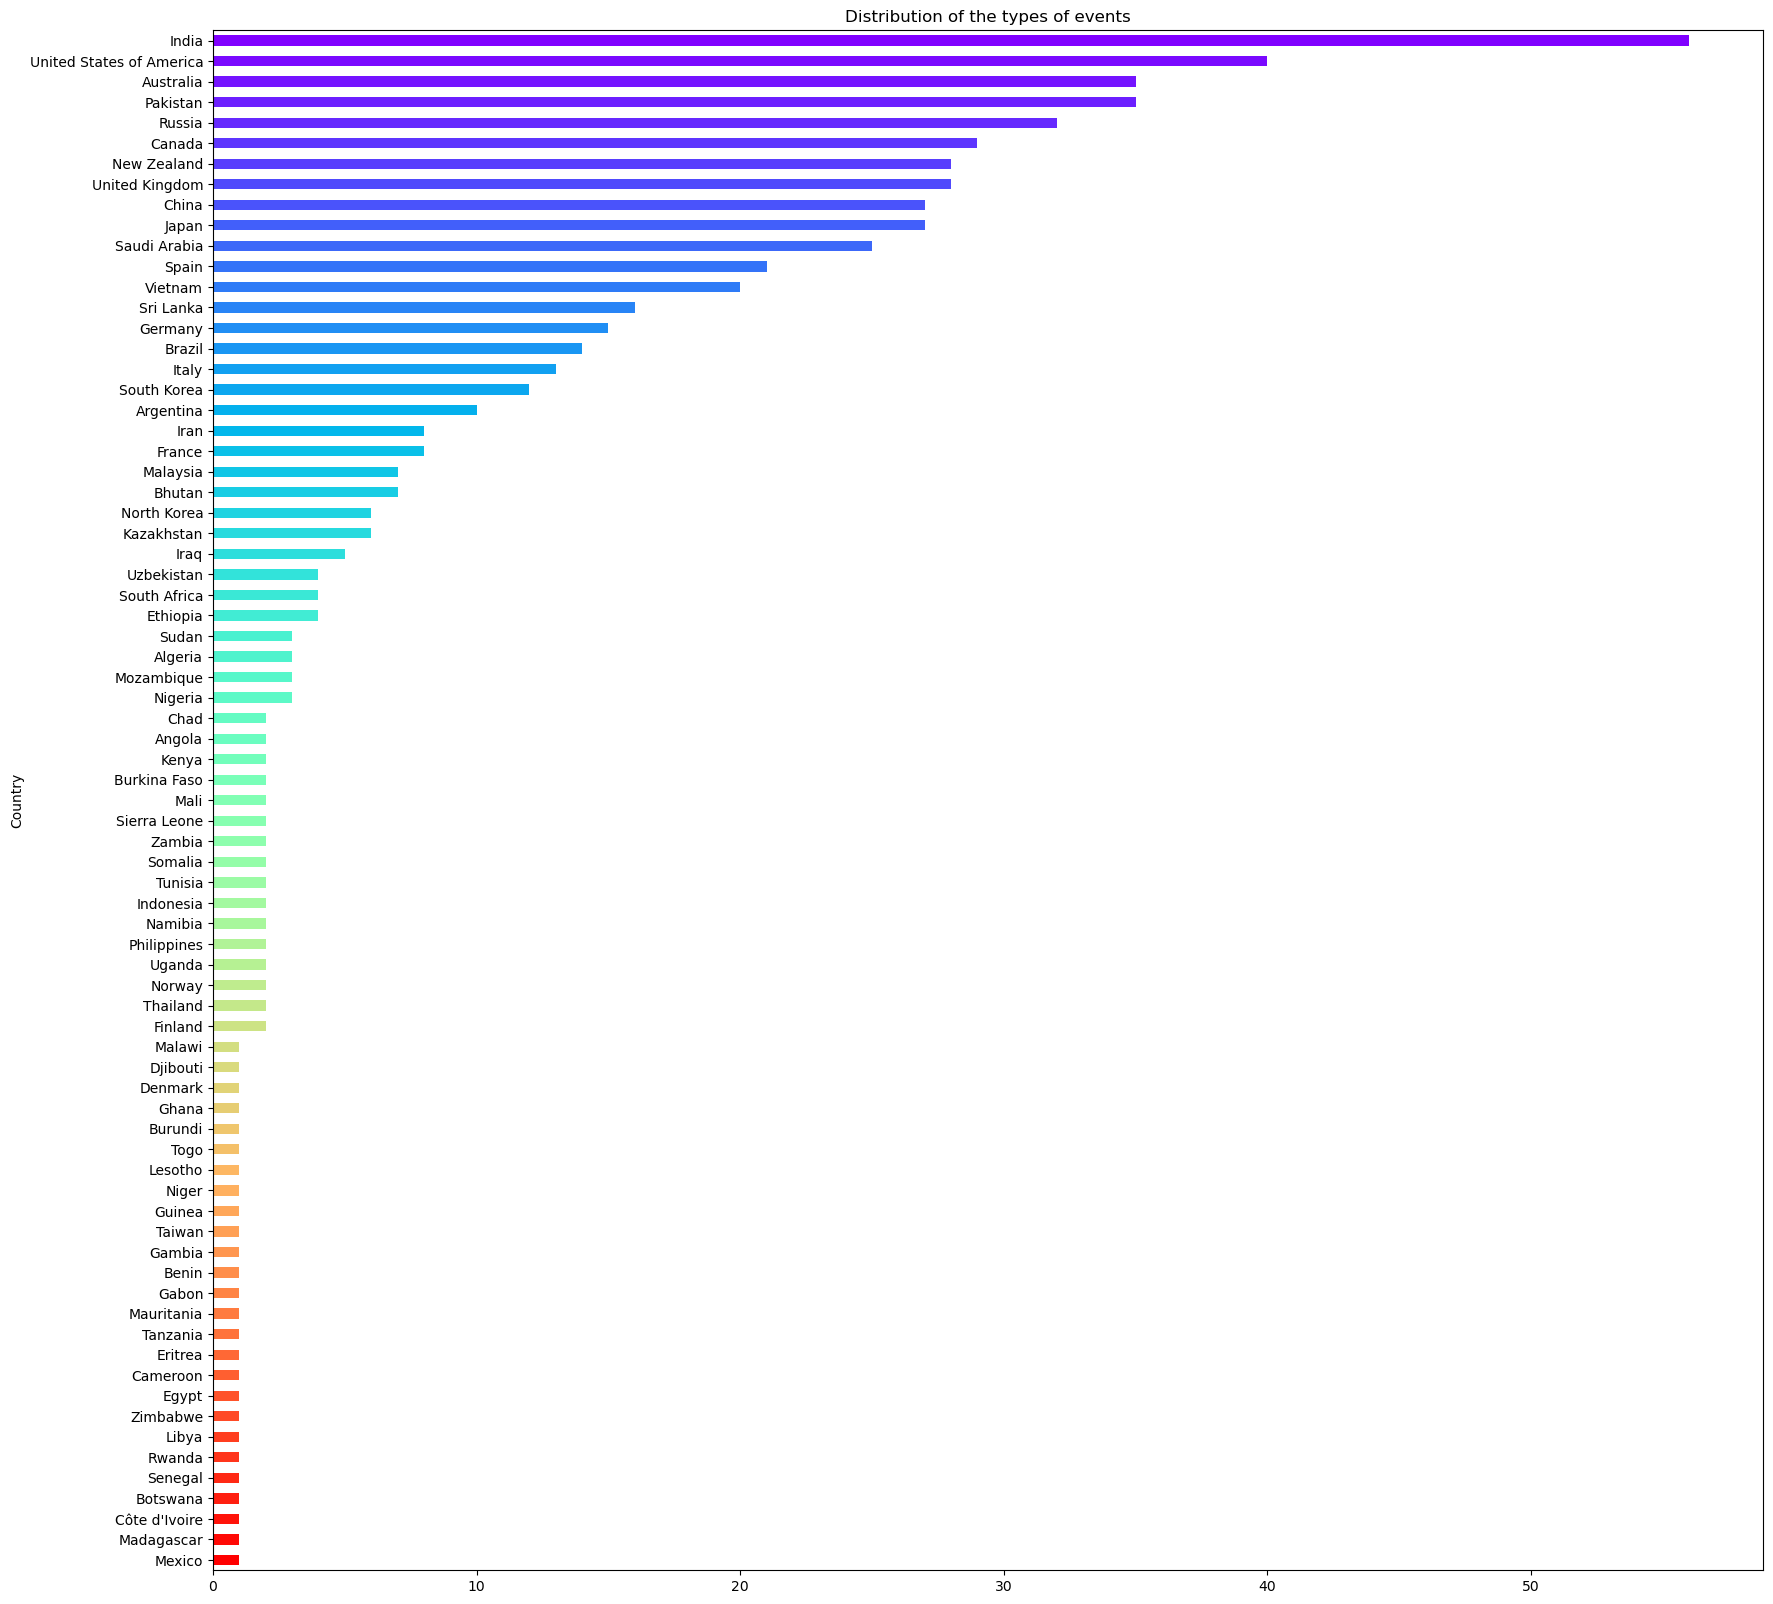

In [76]:
#Country event distribution
# For the bar colors
num_bars = len(country_counts)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

# Plot with rainbow colors assigned to each bar
plt.figure(figsize=(20, 20))
country_counts.plot(kind='barh', color=colors)
plt.title('Distribution of the types of events')
plt.yticks(fontsize=10) 
plt.gca().invert_yaxis() 

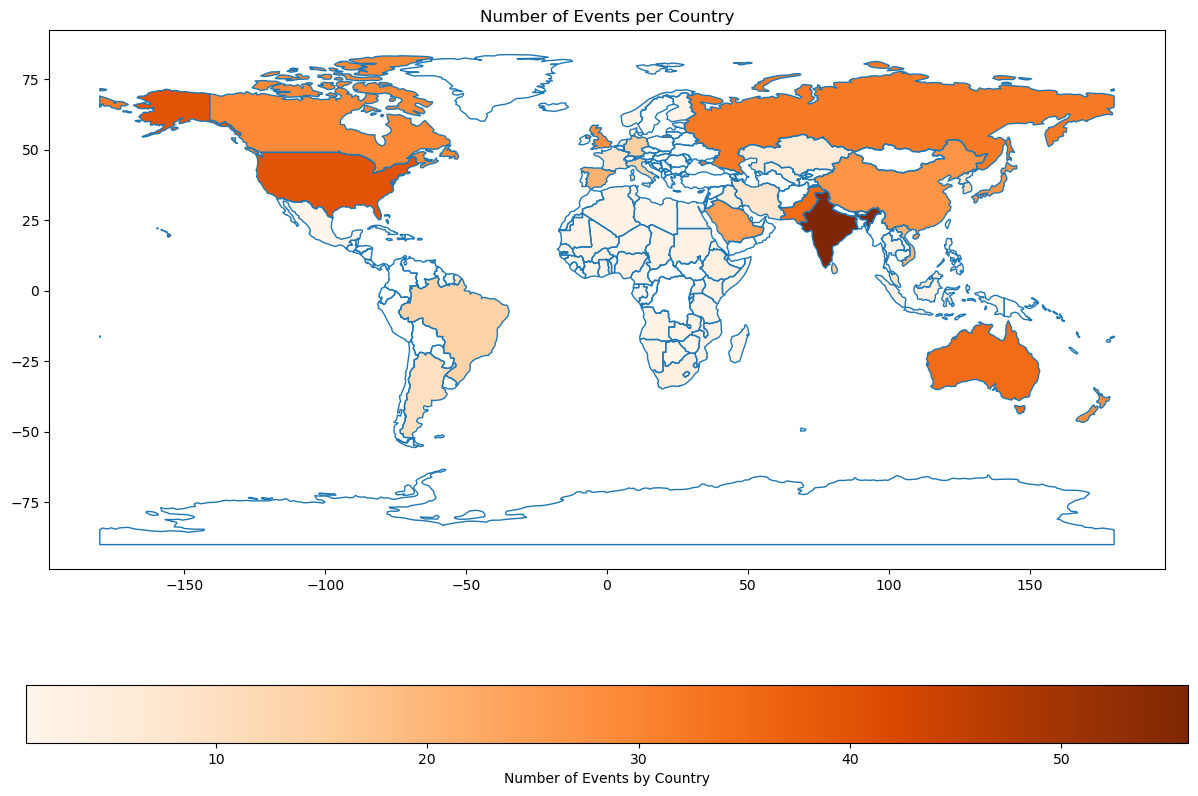

In [77]:
shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
world = world.rename(columns={'NAME': 'Country'})  # Adjust if necessary depending on the shapefile 

# aggregate the number of events per country
event_counts = preprocessed_history['Country'].value_counts()
event_counts = event_counts.reset_index()  # Convert to DataFrame for easier merging
event_counts.columns = ['Country', 'Event_Count']  # Rename columns for clarity


# merge the event counts with the world map by using 'Country' as the key for both DataFrames
merged = world.merge(event_counts, on='Country', how='left')

# plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot country boundaries
world.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='Event_Count', ax=ax, legend=True,
            legend_kwds={'label': "Number of Events by Country",
                         'orientation': "horizontal"},
            cmap='Oranges')

plt.title("Number of Events per Country")
plt.show()

La prochaine étape est de faire des plots, voici mes idées mais rajoutez en à votre guise!! 

- Proportion de chaque genre dans les films sortis chaque année. (lineplot?)
- Heatmap temporelle avec les années et les genres pourrait aussi aider à voir les pics et baisses de popularité des genres.
- Comparer les genres populaires à des périodes historiques précises (avant, pendant, après).
- Ligne temporelle des revenus du box office pour des genres particuliers, avec des annotations pour les films les plus réussis. Les pics ou succès importants peuvent être marqués pour voir si d'autres films de genre similaire ont suivi. (matplotib.pyplot)
- Montrez la durée pendant laquelle un genre reste populaire après le succès d’un film spécifique. Chaque barre représente un genre et montre la période pendant laquelle il est resté en tendance. (barplot?)
- Carte géographique et graphique pour montrer l’origine des films (par pays) et un graphique en barres empilées pour voir comment les genres évoluent dans les différentes régions, en mettant en avant la diffusion de genres américains. (plotly.express.choropleth et seaborn)


Autres idées de chose à regarder par rapport au nouveau dataset: 
- si le nombre de negative outcome historique ont une correlation avec le nombre de comedies or tragedies dans les genre types?